In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, auc, roc_auc_score, cohen_kappa_score, log_loss, confusion_matrix
from collections import deque
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
from keras.layers import Dense, Activation, Input, Reshape, Embedding, concatenate, Dropout
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard, ReduceLROnPlateau
import keras
import tensorflow as tf
import random
import os
from collections import deque
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook, tqdm


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
feature_cols = ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Cat_0', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4']
df = pd.read_csv('synthetic_data.csv')
df.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Cat_0,Cat_1,Cat_2,Cat_3,Cat_4,Treatment,Outcome
0,0.547385,0.676824,0.160835,0.870523,0.662477,1,0,1,1,0,3,1
1,0.712239,0.366255,0.176376,0.658022,0.014532,0,1,0,0,0,1,0
2,0.598097,0.377505,0.180714,0.907436,0.176371,1,1,1,1,0,4,0
3,0.543332,0.302003,0.128728,0.867209,0.011746,1,0,0,1,1,2,1
4,0.421514,0.571057,0.096272,0.738091,0.173162,0,0,1,1,0,2,1


In [3]:
def random_everything(seed=42):
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)

def reset_keras():
    #K = reset_graph_with_backend
    K.clear_session()
    tf.compat.v1.reset_default_graph()


class Actor_critic(object):
    
    def __init__(self, n_actions=5, gamma=1.,
                 numeric_input_dims=10, 
                 maxlen=5000,
                 fc1_dims=64, fc2_dims=64, 
                 bootstrap_size=4096,
                 actor_file='Actor_uplift.h5',
                 critic_file='Critic_uplift.h5',
                 alpha=1e-4, 
                 beta=1e-4,
                 lr_decay=0.9999,
                 lr_min=1e-8,
                 exploit=True
                ):
        
        self.bootstrap_size = bootstrap_size
        self.maxlen = maxlen
        self.exploit = exploit
        self.alpha = alpha
        self.beta = beta
        self.lr_decay = lr_decay
        self.lr_min = lr_min
        self.gamma = gamma
        self.Q = 0

        self.numeric_input_dims = numeric_input_dims
        self.n_actions = n_actions
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        
        self.state_memory = deque(maxlen=maxlen)
        self.action_memory = deque(maxlen=maxlen)
        self.reward_memory = deque(maxlen=maxlen)
        self.new_state_memory = deque(maxlen=maxlen)

        self.action_space = [i for i in range(n_actions)]
        self.actor_file = actor_file
        self.critic_file = critic_file
        
        self.actor, self.critic, self.predict = self.build_actor_critic()
        self.update_model()
        
    def build_actor_critic(self):
        
        random_everything(seed=42)
        num_input   = Input(shape=(self.numeric_input_dims,))
        advantages = Input(shape=[1])
        dense1 = Dense(self.fc1_dims, activation='relu')(num_input)
        dense2 = Dense(self.fc2_dims, activation='relu')(dense1)
        probs = Dense(self.n_actions, activation='softmax')(dense2)
        values = Dense(1, activation='linear')(dense2)         ## value is the maximum of Q value for a given state

        def custom_loss(y_true, y_pred):
            out = K.clip(y_pred, 1e-8, 1-1e-8)   ## don't wanna take the log of 0!
            log_lik = y_true * K.log(out)
            return K.sum(-log_lik*advantages)
        
        actor = Model(input=[num_input, advantages], output=[probs])
        actor.compile(optimizer=Adam(lr=self.alpha), loss=custom_loss)
        
        critic = Model(input=[num_input], output=[values])
        critic.compile(optimizer=Adam(lr=self.beta), loss='mean_squared_error')
        
        predict = Model(input=[num_input], output=[probs])
        
        return actor, critic, predict
    
    def update_model(self):
        
        self.predict.set_weights(self.actor.get_weights())
        
    def choose_action(self, state, seed=42):
        
        state = state[np.newaxis,:]
        num_input = state
        probs = self.predict.predict([num_input])[0]
        random_everything(seed=seed)
        
        if self.exploit:
            action = np.random.choice(self.action_space, p=probs)
        else:
            ## for random control
            action = np.random.choice(self.action_space)
        return action
    
    def store_transition(self, state, action, reward, new_state):
        
        self.action_memory.append(action)
        self.state_memory.append(state)
        self.reward_memory.append(reward)
        self.new_state_memory.append(new_state)

    def sample_buffer(self, bootstrap_size, seed=42):
                
        np.random.seed(seed)
        batch_idx = np.random.choice(len(self.state_memory), bootstrap_size)

        states = np.array(agent.state_memory)[batch_idx]
        action_memory = np.array(agent.action_memory)[batch_idx]
        rewards = np.array(agent.reward_memory)[batch_idx]
        new_states = np.array(agent.new_state_memory)[batch_idx]
        # one-hot-encoded!
        actions = np.zeros([bootstrap_size, self.n_actions])
        actions[np.arange(bootstrap_size), action_memory] = 1
        
        rewards = rewards[:,np.newaxis]
        
        return states, actions, rewards, new_states
        
    def learn(self, seed=42):
        
        if len(self.action_memory) < self.maxlen:
            return
        
        states, actions, rewards, new_states = self.sample_buffer(self.bootstrap_size, seed=seed)

        critic_values = self.critic.predict(states)
        new_critic_values = self.critic.predict(new_states)
        
        targets = rewards + self.gamma*new_critic_values
        advantage = targets - critic_values
        
        random_everything(seed)
        self.actor.fit([states, advantage], actions, verbose=0)
        random_everything(seed)
        self.critic.fit(states, targets, verbose=0)
        
        
        alpha = max(self.actor.optimizer.learning_rate.numpy()*self.lr_decay, self.lr_min)
        beta = max(self.critic.optimizer.learning_rate.numpy()*self.lr_decay, self.lr_min)
        
        self.actor.optimizer.learning_rate.assign(alpha)
        self.critic.optimizer.learning_rate.assign(beta)
        
        self.update_model()
    
    def save_model(self):
        self.actor.save(self.actor_file)
        self.critic.save(self.critic_file)
    
    def load_model(self):
        self.actor.load_weights(self.actor_file)
        self.critic.load_weights(self.critic_file)
        self.update_model()


In [4]:
def get_reward(df, idx, policy_action):
        
    true_action = df.loc[idx, 'Treatment']
    target = df.loc[idx,'Outcome']
    
    if policy_action == true_action:
        return (target)
      
    elif true_action == 0 and policy_action > 0:
        return -(target)
    else:
        return 0
    

In [5]:
indices = np.arange(len(df.iloc[:,:]))
zero_reward_list = []
zero_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 0
    state = state[np.newaxis,:]
    zero_reward = get_reward(df, idx, action)
    zero_reward_list.append(zero_reward)
    
indices = np.arange(len(df.iloc[:,:]))
one_reward_list = []
one_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 1
    state = state[np.newaxis,:]
    one_reward = get_reward(df, idx, action)
    one_reward_list.append(one_reward)

indices = np.arange(len(df.iloc[:,:]))
two_reward_list = []
two_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 2
    state = state[np.newaxis,:]
    two_reward = get_reward(df, idx, action)
    two_reward_list.append(two_reward)
    
indices = np.arange(len(df.iloc[:,:]))
three_reward_list = []
three_Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 3
    state = state[np.newaxis,:]
    three_reward = get_reward(df, idx, action)
    three_reward_list.append(three_reward)
    
indices = np.arange(len(df.iloc[:,:]))
four_reward_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = 4
    state = state[np.newaxis,:]
    four_reward = get_reward(df, idx, action)
    four_reward_list.append(four_reward)

indices = np.arange(len(df.iloc[:,:]))
random_reward_list = []
agent = Actor_critic(exploit=True)
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = agent.choose_action(state, seed=idx)
    state = state[np.newaxis,:]
    random_reward = get_reward(df, idx, action)
    random_reward_list.append(random_reward)

print(np.mean(zero_reward_list))
print(np.mean(one_reward_list))
print(np.mean(two_reward_list))
print(np.mean(three_reward_list))
print(np.mean(four_reward_list))
print(np.mean(random_reward_list))


0.0624
0.0656
0.0628
0.0684
0.0646
0.0654


In [6]:
reset_keras()

feature_cols = ['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Cat_0', 'Cat_1', 'Cat_2', 'Cat_3', 'Cat_4']

NUM_EPISODES = 100
reward_history = []

n_sample = 5000

random_everything(seed=42)

agent = Actor_critic(alpha=1e-5, beta=5e-5, fc1_dims=128, 
                     fc2_dims=128, bootstrap_size=5000, maxlen=n_sample)

best_mean_reward = 0.
mean_reward_history = []

for e in tqdm_notebook(range(NUM_EPISODES)):
    reward_history.append([])
    indices = np.arange(len(df.iloc[:,:]))
    
    random_everything(seed=e%5)
    np.random.shuffle(indices)
    
    idx = indices[0]
    state = df.loc[idx,feature_cols].values
    
    for idx in indices[1:n_sample]:
        #state = df.loc[idx,feature_cols].values
        action = agent.choose_action(state, seed=idx)
        reward = get_reward(df, idx, action)
        reward_history[e].append(reward)
        new_state = df.loc[idx,feature_cols].values
        agent.store_transition(state, action, reward, new_state)
        state = new_state
        
    agent.learn(seed=idx)
    mean_reward = np.mean(reward_history[e])
    
    if e%10 == 0:
        print(f'episode {e} mean_reward {mean_reward:.4}')
    state_memory = np.array(agent.state_memory)
    action_memory = np.array(agent.action_memory)
    reward_memory = np.array(agent.reward_memory)

    actions = np.zeros([len(action_memory), agent.n_actions])
    actions[np.arange(len(action_memory)), action_memory] = 1
        
    mean_reward_history.append(mean_reward)
    if mean_reward > best_mean_reward:
        agent.save_model()
        best_mean_reward = mean_reward
   

episode 0 mean_reward 0.06361
episode 10 mean_reward 0.06441
episode 20 mean_reward 0.06701
episode 30 mean_reward 0.06881
episode 40 mean_reward 0.07081
episode 50 mean_reward 0.07041
episode 60 mean_reward 0.06961
episode 70 mean_reward 0.07201
episode 80 mean_reward 0.07181
episode 90 mean_reward 0.07101



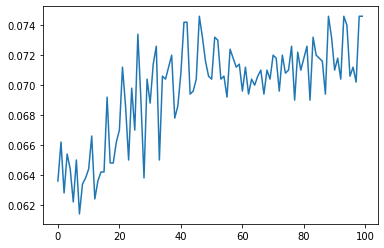

In [7]:
plt.plot(np.arange(len(mean_reward_history)), mean_reward_history)


In [8]:
agent.load_model()
indices = np.arange(len(df.iloc[:,:]))
agent.load_model()
action_list = []
reward_list = []
Q_list = []
for idx in indices[:]:
    state = df.loc[idx,feature_cols].values
    action = agent.choose_action(state, seed=idx)
    state = state[np.newaxis,:]
    Q = agent.predict.predict(state)[0]
    reward = get_reward(df, idx, action)
    action_list.append(action)
    reward_list.append(reward)
    Q_list.append(Q)

print(np.mean(reward_list))
print(np.unique(action_list, return_counts=True))

0.0788
(array([0, 1, 2, 3, 4]), array([1029,  476,  598,  822, 2075]))


Text(0.5, 1.0, 'Cumulative uplift response unweighted reward comparison')

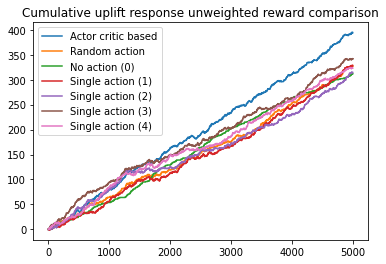

In [9]:
plt.plot(range(len(reward_list)), np.cumsum(reward_list), label='Actor critic based')
plt.plot(range(len(reward_list)), np.cumsum(random_reward_list), label='Random action')
plt.plot(range(len(reward_list)), np.cumsum(zero_reward_list), label='No action (0)')
plt.plot(range(len(reward_list)), np.cumsum(one_reward_list), label='Single action (1)')
plt.plot(range(len(reward_list)), np.cumsum(two_reward_list), label='Single action (2)')
plt.plot(range(len(reward_list)), np.cumsum(three_reward_list), label='Single action (3)')
plt.plot(range(len(reward_list)), np.cumsum(four_reward_list), label='Single action (4)')

plt.xlabel='Number of states'
plt.ylabel='Cumulative reward'
plt.legend()
plt.title('Cumulative uplift response unweighted reward comparison')


In [12]:
agent.critic.predict(state)

array([[2.3823664]], dtype=float32)

In [13]:
state

array([[0.95955637, 0.76233371, 0.0584064 , 0.73094635, 0.01638532,
        1.        , 0.        , 1.        , 0.        , 0.        ]])